In [17]:
####burgers equation soft constraint
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda" )
filepath_to_save_mode = 'soft constraints burgers.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(-1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)

pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


####
t3 = np.linspace(0, 1, 51)
x3 = np.ones((1,1))
ms_t3, ms_x3 = np.meshgrid(t3, x3)
t3_pde = np.ravel(ms_t3).reshape(-1,1)
x3_pde = np.ravel(ms_x3).reshape(-1,1)
pt_x_collocation3 = Variable(torch.from_numpy(x3_pde).float(), requires_grad=True).to(device)
pt_t_collocation3 = Variable(torch.from_numpy(t3_pde).float(), requires_grad=True).to(device)

####
t4 = np.linspace(0, 1, 51)
x4 = -1*np.ones((1,1))
ms_t4, ms_x4 = np.meshgrid(t4, x4)
t4_pde = np.ravel(ms_t4).reshape(-1,1)
x4_pde = np.ravel(ms_x4).reshape(-1,1)
pt_x_collocation4 = Variable(torch.from_numpy(x4_pde).float(), requires_grad=True).to(device)
pt_t_collocation4 = Variable(torch.from_numpy(t4_pde).float(), requires_grad=True).to(device)




act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t+h*h_x-(0.01/(math.pi))* h_xx   
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f1 = h+ torch.sin(math.pi*x)
        f = lossa(f1, 0*f1)
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(10000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2)+net.loss_BC(pt_t_collocation3, pt_x_collocation3)+net.loss_BC1(pt_t_collocation4, pt_x_collocation4)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:0.5007404685020
epoch:101,loss:0.1754114329815
epoch:201,loss:0.1476561427116
epoch:301,loss:0.1263419836760
epoch:401,loss:0.1149716526270
epoch:501,loss:0.1129724606872
epoch:601,loss:0.1061468943954
epoch:701,loss:0.1013681441545
epoch:801,loss:0.1223715767264
epoch:901,loss:0.0931655243039
epoch:1001,loss:0.0903999805450
epoch:1101,loss:0.0879710689187
epoch:1201,loss:0.0844405591488
epoch:1301,loss:0.0799435973167
epoch:1401,loss:0.0704669728875
epoch:1501,loss:0.0742200911045
epoch:1601,loss:0.0821655243635
epoch:1701,loss:0.0531524680555
epoch:1801,loss:0.0589744374156
epoch:1901,loss:0.0504019260406
epoch:2001,loss:0.0437653437257
epoch:2101,loss:0.1056044325233
epoch:2201,loss:0.0466054305434
epoch:2301,loss:0.0386254638433
epoch:2401,loss:0.0396870337427
epoch:2501,loss:0.0366131812334
epoch:2601,loss:0.0411016047001
epoch:2701,loss:0.0509035289288
epoch:2801,loss:0.0281447917223
epoch:2901,loss:0.0857153981924
epoch:3001,loss:0.0397157222033
epoch:3101,loss:0.02

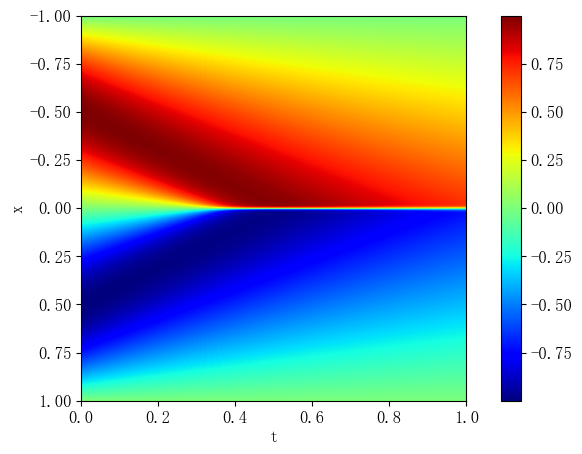

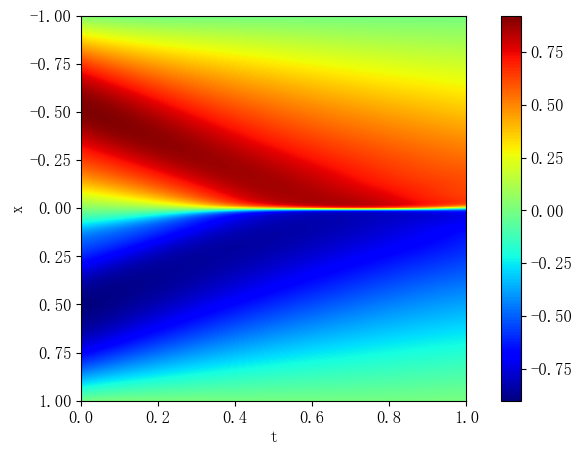

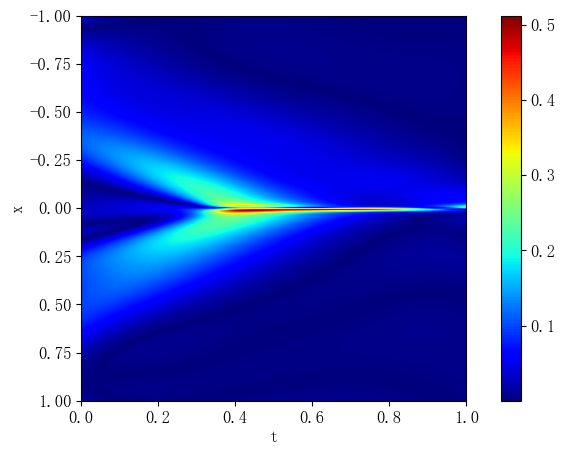

rmse: 0.06779315508977103  r2: 0.9878225145035221


In [18]:
####burgers equation plotting（Soft constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda")
filepath_to_save_mode = 'soft constraints burgers.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1, 51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t+h*h_x-(0.01/(torch.pi))* h_xx   
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f = h+ torch.sin(torch.pi*x)
        f = lossa(h, pt_z_collocation2)
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f
from numpy import genfromtxt
net = Net().to(device)
net.load_state_dict(torch.load('soft constraints burgers.pt',map_location=device))   
data1 = genfromtxt("buger.csv", delimiter=',')
h00c=np.asarray(data1.data)
t_bc = np.linspace(0, 1, 100)
x_bc = np.linspace(-1, 1, 256)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1=h0.cpu().detach().numpy()
u1 = u1.reshape(ms_t.shape)
df = pd.DataFrame(u1) 
df.to_csv("0.001.csv")
c=df.iloc[-1]
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('FEM burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('PINN soft constraints burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(u1-h00c), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('ERROR soft constraints burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)

In [19]:
####burgers equation hard constraint
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda" )
filepath_to_save_mode = 'hard constraints burgers.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)





act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = -torch.sin(math.pi*x) + (x+1)*(x-1)*t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t+h*h_x-(0.01/(math.pi))* h_xx   
        f = lossa(f1, 0 * f1)
        return f


tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(10000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:1.2142809629440
epoch:101,loss:0.4416093528271
epoch:201,loss:0.4217778444290
epoch:301,loss:0.4009447395802
epoch:401,loss:0.3425317406654
epoch:501,loss:0.2608307600021
epoch:601,loss:0.2498930841684
epoch:701,loss:0.2401899248362
epoch:801,loss:0.2274896949530
epoch:901,loss:0.2072843462229
epoch:1001,loss:0.1506007611752
epoch:1101,loss:0.1028513461351
epoch:1201,loss:0.0980771332979
epoch:1301,loss:0.0629108101130
epoch:1401,loss:0.0427795983851
epoch:1501,loss:0.0383220538497
epoch:1601,loss:0.0284917373210
epoch:1701,loss:0.0265306401998
epoch:1801,loss:0.0220542438328
epoch:1901,loss:0.0229861736298
epoch:2001,loss:0.0180526487529
epoch:2101,loss:0.0199588332325
epoch:2201,loss:0.0155382473022
epoch:2301,loss:0.0186476856470
epoch:2401,loss:0.0168080404401
epoch:2501,loss:0.0155395260081
epoch:2601,loss:0.0138485021889
epoch:2701,loss:0.0117208138108
epoch:2801,loss:0.0143786584958
epoch:2901,loss:0.0111576020718
epoch:3001,loss:0.0108817648143
epoch:3101,loss:0.01

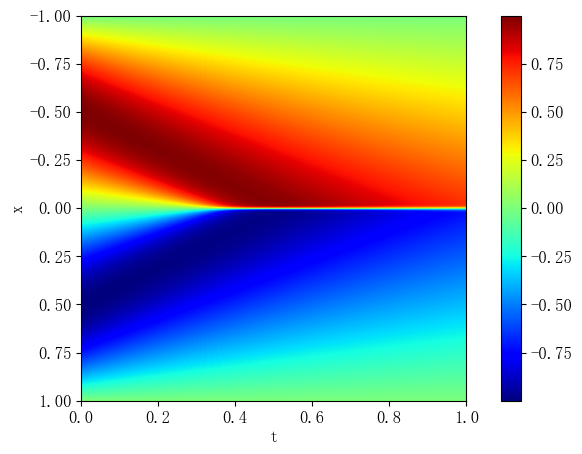

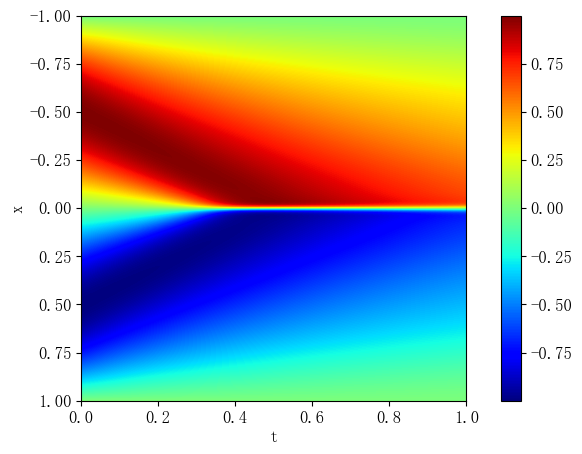

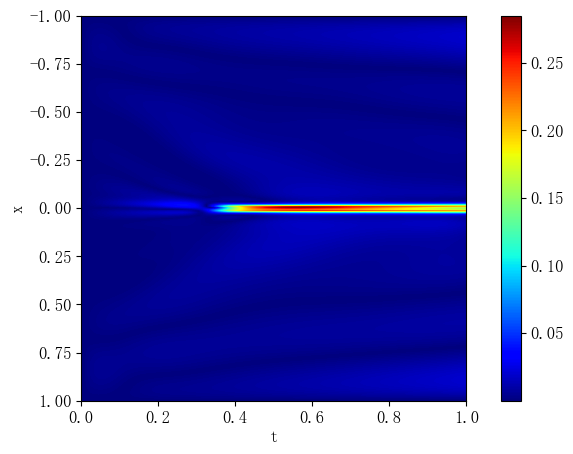

rmse: 0.024609929747885253  r2: 0.9983952526171859


In [20]:
####burgers equation plotting（Hard constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda")
filepath_to_save_mode = 'hard constraints burgers.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1, 51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = -torch.sin(math.pi*x) + (x+1)*(x-1)*t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t+h*h_x-(0.01/(math.pi))* h_xx   
        f = lossa(f1, 0 * f1)
        return f


net = Net().to(device)
net.load_state_dict(torch.load('hard constraints burgers.pt',map_location=device))   
data1 = genfromtxt("buger.csv", delimiter=',')
h00c=np.asarray(data1.data)
t_bc = np.linspace(0, 1, 100)
x_bc = np.linspace(-1, 1, 256)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1=h0.cpu().detach().numpy()
u1 = u1.reshape(ms_t.shape)
df = pd.DataFrame(u1)
df.to_csv("0.001.csv")
c=df.iloc[-1]
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('FEM burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('PINN hard constraints burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(u1-h00c), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('error hard constraints burgers.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)


In [34]:
####matlab求解burgers

%% Problem description.
% Solving
%   u_t = -u*(u)' + (0.01/pi)*u",
% for x in [-1,1] and t in [0,1], subject to
%   u = 0 at x = -1
% and
%   u = 0 at x = 1
tic
%% Problem set-up
% Create an interval of the space domain...
dom = [-1,1];
%...and specify a sampling of the time domain:
t = 0:.01:0.99;

% Make the right-hand side of the PDE.
pdefun = @(t,x,u) -u.*diff(u)+0.01./pi.*diff(u,2);

% Assign boundary conditions.
bc.left = 0;
bc.right = 0;

% Construct a chebfun of the space variable on the domain,
x = chebfun(@(x) x, dom);
% and of the initial condition.
u0 = -sin(pi*x);

%% Setup preferences for solving the problem.
opts = pdeset('Eps', 1e-7, 'HoldPlot', 'on', 'Ylim', [0,0.8]);

%% Call pde23t to solve the problem.
[t, u] = pde23t(pdefun, t, u0, bc, opts);

%% Plot the solution.
figure
% surf(u)
xlabel('x'), ylabel('t')
toc

x = (linspace(-1,1,256))';
time = 1:100;

usol(:,time) = u(x,time);
surf(usol)


filename = 'burgers_shock_IC_sinpi.mat';

save(filename,'t','x','usol')

SyntaxError: invalid syntax (3834655478.py, line 15)

import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15 ** 2)

def fun(x, u):
    return np.vstack((u[1], 100 * (k(x) * u[0] + np.sin(2 * np.pi * x))))

def bc(ua, ub):
    return np.array([ua[0], ub[0]])

x = np.linspace(0, 1, 100)
u_init = np.zeros((2, x.size))

res = solve_bvp(fun, bc, x, u_init)

if res.status == 0:
    x_plot = np.linspace(0, 1, 100)
    u_plot = res.sol(x_plot)[0]
    plt.plot(x_plot, u_plot, label='u(x)')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.show()

    # Combine x and u data and save to CSV
    data = np.column_stack((x_plot, u_plot))
    np.savetxt("data.csv", data, delimiter=",")
else:
    print("无法求解")


In [ ]:
####二维波动方程有限差分
import numpy as np
import matplotlib.pylab as plt

def FDM(xmin, xmax, nx, dx, 
        ymin, ymax, ny, dy, 
        nt, dt, 
        x, y, u, c, BC):
    # FDM for reference
    u[0, :, :] = np.exp(-(x - 3) ** 2) * np.exp(-(y - 3) ** 2)
    u[1, :, :] = u[0, :, :]
    for n in range(1, nt - 1):
        if n % int(1e2) == 0:
            print(">>>>> FDM computing... n =", n)
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u[n + 1, i, j] = 2 * u[n, i, j] - u[n - 1, i, j] \
                                + (c * dt / dx) ** 2 * (u[n, i + 1, j] - 2 * u[n, i, j] + u[n, i - 1, j]) \
                                + (c * dt / dy) ** 2 * (u[n, i, j + 1] - 2 * u[n, i, j] + u[n, i, j - 1])
        if BC == "Dir":
            for i in range(1, nx - 1):
                u[n + 1, i,  0] = 0.
                u[n + 1, i, -1] = 0.
            for j in range(1, ny - 1):
                u[n + 1,  0, j] = 0.
                u[n + 1, -1, j] = 0.


    # plot FDM solutions
    fig  = plt.figure(figsize = (16, 4))
    # snapshot 1
    ax   = fig.add_subplot(1, 3, 1, projection = "3d")
    surf = ax.plot_surface(x, y, u[0, :, :], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("x", fontstyle = "italic")
    ax.set_ylabel("y", fontstyle = "italic")
    ax.set_zlabel("u (x, y)", fontstyle = "italic")
    # snapshot 2
    ax   = fig.add_subplot(1, 3, 2, projection = "3d")
    surf = ax.plot_surface(x, y, u[10, :, :], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("x", fontstyle = "italic")
    ax.set_ylabel("y", fontstyle = "italic")
    ax.set_zlabel("u (x, y)", fontstyle = "italic")
    # snapshot 3
    ax   = fig.add_subplot(1, 3, 3, projection = "3d")
    surf = ax.plot_surface(x, y, u[-1, :, :], cmap = "coolwarm", linewidth = 0, vmin = -.5, vmax = .5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("x", fontstyle = "italic")
    ax.set_ylabel("y", fontstyle = "italic")
    ax.set_zlabel("u (x, y)", fontstyle = "italic")
    plt.show()

    return u
def main():
    # Parameters
    xmin, xmax = 0., 6.
    ymin, ymax = 0., 6.
    nx, ny = 100, 100
    dx, dy = (xmax - xmin) / (nx - 1), (ymax - ymin) / (ny - 1)
    nt, dt = 100, 1e-2
    c = 1
    BC = "Dir"  # or "Neu" for Neumann boundary conditions

    # Generate grid
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    x, y = np.meshgrid(x, y)

    # Initialize u
    u = np.zeros((nt, nx, ny))

    # Call FDM function
    u = FDM(xmin, xmax, nx, dx, ymin, ymax, ny, dy, nt, dt, x, y, u, c, BC)
    np.savetxt("Wave1.csv", u[0, :, :], delimiter=",")
    np.savetxt("Wave2.csv", u[10, :, :], delimiter=",")
    np.savetxt("Wave3.csv", u[-1, :, :], delimiter=",")

if __name__ == "__main__":
    main()



In [35]:
####wave equation（soft constraint）
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'wave.pt'
####
####
t = np.linspace(0, 1, 21)
x = np.linspace(0, 6,31)
y = np.linspace(0, 6,31)
ms_t, ms_x,ms_y = np.meshgrid(t, x,y)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
y_pde = np.ravel(ms_y).reshape(-1,1)
pt_y_collocation = Variable(torch.from_numpy(y_pde).float(), requires_grad=True).to(device)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(0, 6,31)
y2 = np.linspace(0, 6,31)
ms_t2, ms_x2,  ms_y2= np.meshgrid(t2, x2,y2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
y2_pde = np.ravel(ms_y2).reshape(-1,1)
pt_y_collocation2 = Variable(torch.from_numpy(y2_pde).float(), requires_grad=True).to(device)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)



act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(3, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x,y):
        T =2*t-1
        X =2*(x)/6-1
        Y = 2*(y)/6-1
        inputs = torch.cat([T, X,Y], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x,y):
        h =net(t,x,y)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        h_y = torch.autograd.grad(h.sum(), y, create_graph=True)[0]
        h_yy = torch.autograd.grad(h_y.sum(), y, create_graph=True)[0]
              
        
        f1 =  h_tt-(h_xx+h_yy)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x,y):
        h =net(t,x,y)
        f1 = h-torch.exp(-(x - 3)**2) *torch.exp(-(y - 3)**2)
        ff1 = lossa(f1, 0*f1)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        ff2 = lossa(h_t, 0*h_t)
        f = ff1+ff2
        return f
    
    def loss_BC1(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)
        f = f1
        return f
    def loss_BC2(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)

        f = f1
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(3000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation, pt_y_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2, pt_y_collocation2)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:0.0404116213322
epoch:101,loss:0.0192091315985
epoch:201,loss:0.0112565057352
epoch:301,loss:0.0078772176057
epoch:401,loss:0.0046929037198
epoch:501,loss:0.0027786458377
epoch:601,loss:0.0017247200012
epoch:701,loss:0.0011054773349
epoch:801,loss:0.0007839654572
epoch:901,loss:0.0005779244239
epoch:1001,loss:0.0004483736702
epoch:1101,loss:0.0003518013982
epoch:1201,loss:0.0002771054569
epoch:1301,loss:0.0002443697304
epoch:1401,loss:0.0002378491336
epoch:1501,loss:0.0001613525237
epoch:1601,loss:0.0001426781528
epoch:1701,loss:0.0001371072285
epoch:1801,loss:0.0001188410679
epoch:1901,loss:0.0001117077773
epoch:2001,loss:0.0001034890738
epoch:2101,loss:0.0000973208662
epoch:2201,loss:0.0000924587075
epoch:2301,loss:0.0001101599264
epoch:2401,loss:0.0000838067863
epoch:2501,loss:0.0000845020113
epoch:2601,loss:0.0000769588951
epoch:2701,loss:0.0001288844651
epoch:2801,loss:0.0000710858585
epoch:2901,loss:0.0000681253805
userd: 138.07592s


rmse: 0.005501954272501556  r2: 0.9991460814499944
rmse: 0.005267028568079592  r2: 0.9992003169826732
rmse: 0.009987343242512438  r2: 0.9879137977826161


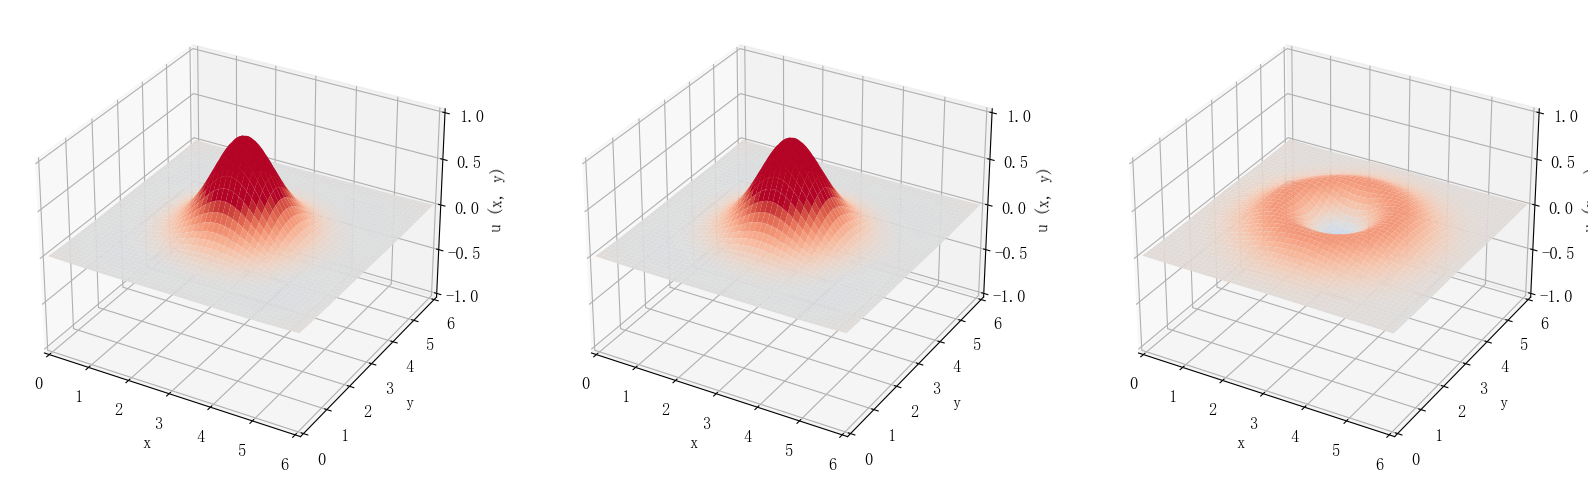

In [36]:
####wave equation plotting（Soft constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'wave.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(0, 6,51)
y = np.linspace(0, 6,51)
ms_t, ms_x,ms_y = np.meshgrid(t, x,y)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
y_pde = np.ravel(ms_y).reshape(-1,1)
pt_y_collocation = Variable(torch.from_numpy(y_pde).float(), requires_grad=True).to(device)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(0, 6,51)
y2 = np.linspace(0, 6,51)
ms_t2, ms_x2,  ms_y2= np.meshgrid(t2, x2,y2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
y2_pde = np.ravel(ms_y2).reshape(-1,1)

pt_y_collocation2 = Variable(torch.from_numpy(y2_pde).float(), requires_grad=True).to(device)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)



act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(3, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x,y):
        T =2*t-1
        X =2*(x)/6-1
        Y = 2*(y)/6-1
        inputs = torch.cat([T, X,Y], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x,y):
        h =net(t,x,y)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        h_y = torch.autograd.grad(h.sum(), y, create_graph=True)[0]
        h_yy = torch.autograd.grad(h_y.sum(), y, create_graph=True)[0]
              
        
        f1 =  h_tt-(h_xx+h_yy)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x,y):
        h =net(t,x,y)
        f1 = h-torch.exp(-(x - 3)**2) *torch.exp(-(y - 3)**2)
        ff1 = lossa(f1, 0*f1)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        ff2 = lossa(h_t, 0*h_t)
        f = ff1+ff2
        return f
    
    def loss_BC1(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)
        f = f1
        return f
    def loss_BC2(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)

        f = f1
        return f


net = Net().to(device)
net.load_state_dict(torch.load('wave.pt',map_location=device))   
time =  [0, 0.1, 1]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), subplot_kw={'projection': '3d'})

file_names = ['Wave1.csv', 'Wave2.csv', 'Wave3.csv']
for i, ax in enumerate(axs):
    x = np.linspace(0, 6, 100)
    y = np.linspace(0, 6, 100)
    ms_x, ms_y = np.meshgrid(x, y)
    xxg = np.ravel(ms_x).reshape(-1,1)
    yyg = np.ravel(ms_y).reshape(-1,1)
    ttg = np.ones((len(xxg),1))*time[i]
    
    # Load the CSV data for this iteration
    data_path = os.path.join( file_names[i])
    data1 = np.genfromtxt(data_path, delimiter=',')
    h00c = np.asarray(data1.data)
    
    pt_x_collocation = Variable(torch.from_numpy(xxg).float(), requires_grad=True).to(device)
    pt_y_collocation = Variable(torch.from_numpy(yyg).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(ttg).float(), requires_grad=True).to(device)
    p_hat = net(pt_t_collocation,pt_x_collocation,pt_y_collocation)[:, 0].reshape(-1, 1)
    h0 = p_hat
    h00 =h0.cpu().detach().numpy()
    h00 = h00.reshape(ms_x.shape)  
    u1 = np.asarray(h00.data)
    surf = ax.plot_surface(ms_x,ms_y,h00, cmap='coolwarm',linewidth=0, vmin = -.5, vmax = .5)
    ax.set_xlabel("x", fontstyle = "italic")
    ax.set_ylabel("y", fontstyle = "italic")
    ax.set_zlabel("u (x, y)", fontstyle = "italic")
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_zlim(-1, 1)
    mse = (np.sum((h00c - u1) ** 2))/len(ttg)
    rmse = mse**0.5
    r2 = 1-mse/ np.var(h00c)
    print("rmse:",rmse," r2:",r2)
plt.show()  




In [37]:
####wave equation （Hard constraint）
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'wave2.pt'
####
####
t = np.linspace(0, 1, 21)
x = np.linspace(0, 6,31)
y = np.linspace(0, 6,31)
ms_t, ms_x,ms_y = np.meshgrid(t, x,y)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
y_pde = np.ravel(ms_y).reshape(-1,1)
pt_y_collocation = Variable(torch.from_numpy(y_pde).float(), requires_grad=True).to(device)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(0, 6,31)
y2 = np.linspace(0, 6,31)
ms_t2, ms_x2,  ms_y2= np.meshgrid(t2, x2,y2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
y2_pde = np.ravel(ms_y2).reshape(-1,1)
pt_y_collocation2 = Variable(torch.from_numpy(y2_pde).float(), requires_grad=True).to(device)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)



act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(3, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)

    def Hard_Constraints(self, t, x,y, nn_outputs):
        output_hard = torch.exp(-(x - 3)**2) *torch.exp(-(y - 3)**2) + t * nn_outputs/36
        return output_hard
    def forward(self, t, x,y):
        T =2*t-1
        X =2*(x)/6-1
        Y = 2*(y)/6-1
        inputs = torch.cat([T, X,Y], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,y,nn_output)
        return output
    def loss_pde(net,t, x,y):
        h =net(t,x,y)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        h_y = torch.autograd.grad(h.sum(), y, create_graph=True)[0]
        h_yy = torch.autograd.grad(h_y.sum(), y, create_graph=True)[0]
          
        f1 =  h_tt-(h_xx+h_yy)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x,y):
        h =net(t,x,y)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        ff2 = lossa(h_t, 0*h_t)
        f = ff2
        return f
    
    def loss_BC1(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)
        f = f1
        return f
    def loss_BC2(net,t, x,y):
        h =net(t,x,y)
        f1 = lossa(h, 0*h)

        f = f1
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(3000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation, pt_y_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2, pt_y_collocation2)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:0.3269070982933
epoch:101,loss:0.2913199961185
epoch:201,loss:0.2077322304249
epoch:301,loss:0.1464165002108
epoch:401,loss:0.0335511192679
epoch:501,loss:0.0204576775432
epoch:601,loss:0.0158189572394
epoch:701,loss:0.0111689120531
epoch:801,loss:0.0070393849164
epoch:901,loss:0.0049290917814
epoch:1001,loss:0.0037014011759
epoch:1101,loss:0.0026883396786
epoch:1201,loss:0.0021990719251
epoch:1301,loss:0.0018576085567
epoch:1401,loss:0.0013974426547
epoch:1501,loss:0.0009796079248
epoch:1601,loss:0.0007523433887
epoch:1701,loss:0.0006900696899
epoch:1801,loss:0.0005543211009
epoch:1901,loss:0.0005039598327
epoch:2001,loss:0.0003770846524
epoch:2101,loss:0.0003279372468
epoch:2201,loss:0.0002887882292
epoch:2301,loss:0.0007405815995
epoch:2401,loss:0.0002299881889
epoch:2501,loss:0.0010689978953
epoch:2601,loss:0.0004906100803
epoch:2701,loss:0.0002170302323
epoch:2801,loss:0.0002554928651
epoch:2901,loss:0.0001684786112
userd: 135.07212s


rmse: 2.4910585219085843e-08  r2: 0.9999999999999825
rmse: 0.00039427943993206206  r2: 0.9999955187952551
rmse: 0.010537727938584521  r2: 0.9865449948533248


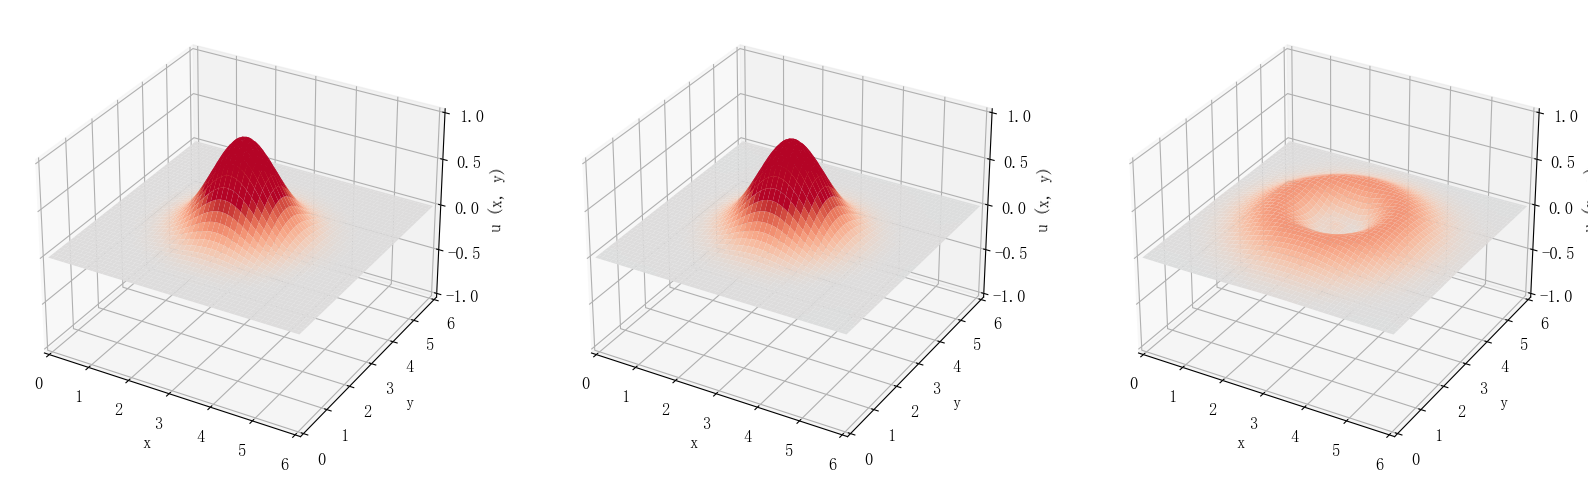

In [38]:
####wave equation plotting（Hard constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'wave2.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(0, 6,51)
y = np.linspace(0, 6,51)
ms_t, ms_x,ms_y = np.meshgrid(t, x,y)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
y_pde = np.ravel(ms_y).reshape(-1,1)
pt_y_collocation = Variable(torch.from_numpy(y_pde).float(), requires_grad=True).to(device)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(3, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)

    def Hard_Constraints(self, t, x,y, nn_outputs):
        output_hard = torch.exp(-(x - 3)**2) *torch.exp(-(y - 3)**2) + t * nn_outputs/36
        return output_hard
    def forward(self, t, x,y):
        T =2*t-1
        X =2*(x)/6-1
        Y = 2*(y)/6-1
        inputs = torch.cat([T, X,Y], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,y,nn_output)
        return output
    def loss_pde(net,t, x,y):
        h =net(t,x,y)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        h_y = torch.autograd.grad(h.sum(), y, create_graph=True)[0]
        h_yy = torch.autograd.grad(h_y.sum(), y, create_graph=True)[0]
          
        f1 =  h_tt-(h_xx+h_yy)
        f = lossa(f1, 0 * f1)
        return f


net = Net().to(device)
net.load_state_dict(torch.load('wave2.pt',map_location=device))   
time =  [0, 0.1, 1]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), subplot_kw={'projection': '3d'})

file_names = ['Wave1.csv', 'Wave2.csv', 'Wave3.csv']
for i, ax in enumerate(axs):
    x = np.linspace(0, 6, 100)
    y = np.linspace(0, 6, 100)
    ms_x, ms_y = np.meshgrid(x, y)
    xxg = np.ravel(ms_x).reshape(-1,1)
    yyg = np.ravel(ms_y).reshape(-1,1)
    ttg = np.ones((len(xxg),1))*time[i]
    
    # Load the CSV data for this iteration
    data_path = os.path.join( file_names[i])
    data1 = np.genfromtxt(data_path, delimiter=',')
    h00c = np.asarray(data1.data)
    
    pt_x_collocation = Variable(torch.from_numpy(xxg).float(), requires_grad=True).to(device)
    pt_y_collocation = Variable(torch.from_numpy(yyg).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(ttg).float(), requires_grad=True).to(device)
    p_hat = net(pt_t_collocation,pt_x_collocation,pt_y_collocation)[:, 0].reshape(-1, 1)
    h0 = p_hat
    h00 =h0.cpu().detach().numpy()
    h00 = h00.reshape(ms_x.shape)  
    u1 = np.asarray(h00.data)
    surf = ax.plot_surface(ms_x,ms_y,h00, cmap='coolwarm',linewidth=0, vmin = -.5, vmax = .5)
    ax.set_xlabel("x", fontstyle = "italic")
    ax.set_ylabel("y", fontstyle = "italic")
    ax.set_zlabel("u (x, y)", fontstyle = "italic")
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_zlim(-1, 1)
    mse = (np.sum((h00c - u1) ** 2))/len(ttg)
    rmse = mse**0.5
    r2 = 1-mse/ np.var(h00c)
    print("rmse:",rmse," r2:",r2)
plt.show()  




In [21]:
####AC equation（Soft constraint）
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'soft constraint AC.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(-1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)

pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


####
t3 = np.linspace(0, 1, 51)
x3 = np.ones((1,1))
ms_t3, ms_x3 = np.meshgrid(t3, x3)
t3_pde = np.ravel(ms_t3).reshape(-1,1)
x3_pde = np.ravel(ms_x3).reshape(-1,1)
pt_x_collocation3 = Variable(torch.from_numpy(x3_pde).float(), requires_grad=True).to(device)
pt_t_collocation3 = Variable(torch.from_numpy(t3_pde).float(), requires_grad=True).to(device)





act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t-0.0001*h_xx+5*h**3-5*h     
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f1 = h- x**2*torch.cos(math.pi*x)
        f = lossa(f1, 0*f1)
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        f = lossa(h1-h2, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        h1_x = torch.autograd.grad(h1.sum(), x, create_graph=True)[0]
        h2_x = torch.autograd.grad(h2.sum(), x, create_graph=True)[0]
        f = lossa(h1_x-h2_x, 0*h1)
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(50000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:0.2526012361050
epoch:101,loss:0.1534025073051
epoch:201,loss:0.1485486626625
epoch:301,loss:0.1480758190155
epoch:401,loss:0.1477056443691
epoch:501,loss:0.1475532799959
epoch:601,loss:0.1474449485540
epoch:701,loss:0.1473734676838
epoch:801,loss:0.1473434716463
epoch:901,loss:0.1472255140543
epoch:1001,loss:0.1472766995430
epoch:1101,loss:0.1471769660711
epoch:1201,loss:0.1470958590508
epoch:1301,loss:0.1471809744835
epoch:1401,loss:0.1470561027527
epoch:1501,loss:0.1469880491495
epoch:1601,loss:0.1469651609659
epoch:1701,loss:0.1469623893499
epoch:1801,loss:0.1468980461359
epoch:1901,loss:0.1469023227692
epoch:2001,loss:0.1468611359596
epoch:2101,loss:0.1469390094280
epoch:2201,loss:0.1468505710363
epoch:2301,loss:0.1468223780394
epoch:2401,loss:0.1468547284603
epoch:2501,loss:0.1467990428209
epoch:2601,loss:0.1468344330788
epoch:2701,loss:0.1467830538750
epoch:2801,loss:0.1477772891521
epoch:2901,loss:0.1467738896608
epoch:3001,loss:0.1467524766922
epoch:3101,loss:0.14

epoch:25201,loss:0.0008082797867
epoch:25301,loss:0.0039289686829
epoch:25401,loss:0.0007889965200
epoch:25501,loss:0.0007772379904
epoch:25601,loss:0.0021254797466
epoch:25701,loss:0.0007588227163
epoch:25801,loss:0.0007483637310
epoch:25901,loss:0.0007665601443
epoch:26001,loss:0.0007332707173
epoch:26101,loss:0.0007244828157
epoch:26201,loss:0.0007215130609
epoch:26301,loss:0.0007118468056
epoch:26401,loss:0.0007175640203
epoch:26501,loss:0.0007009250112
epoch:26601,loss:0.0007206249866
epoch:26701,loss:0.0006923304754
epoch:26801,loss:0.0006858331617
epoch:26901,loss:0.0009603709914
epoch:27001,loss:0.0006766506704
epoch:27101,loss:0.0006740560057
epoch:27201,loss:0.0006979229511
epoch:27301,loss:0.0006662765518
epoch:27401,loss:0.0006613115547
epoch:27501,loss:0.0006644133828
epoch:27601,loss:0.0006561812479
epoch:27701,loss:0.0030157133006
epoch:27801,loss:0.0006518106675
epoch:27901,loss:0.0006476433482
epoch:28001,loss:0.0006470979424
epoch:28101,loss:0.0006439327262
epoch:2820

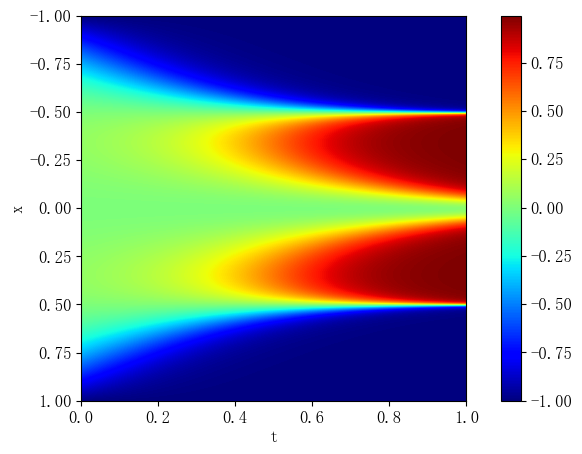

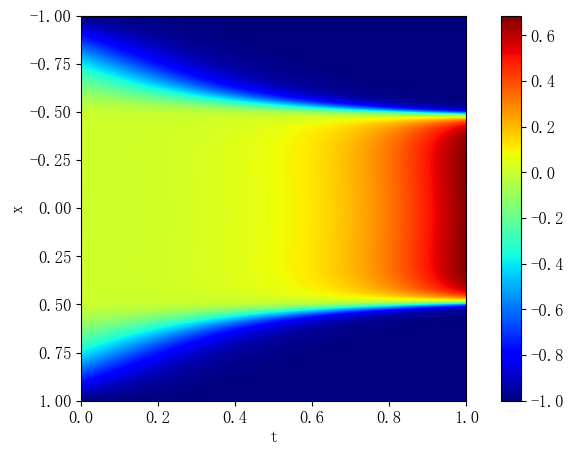

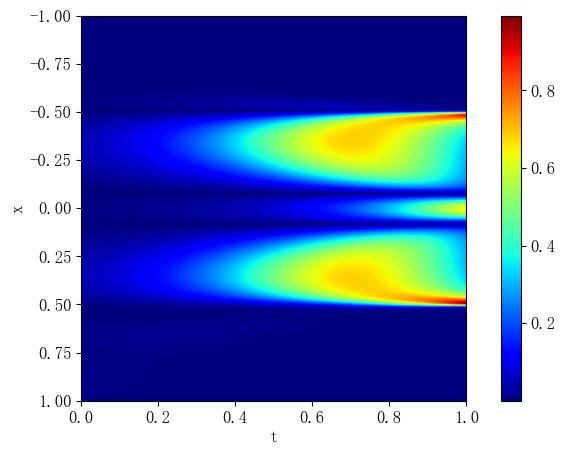

rmse: 0.24628242080723906  r2: 0.8668579043459068


In [22]:
####AC equation plotting（Soft constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'soft constraint AC.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1, 51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t-0.0001*h_xx+5*h**3-5*h     
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f1 = h- x**2*torch.cos(math.pi*x)
        f = lossa(f1, 0*f1)
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        f = lossa(h1-h2, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        h1_x = torch.autograd.grad(h1.sum(), x, create_graph=True)[0]
        h2_x = torch.autograd.grad(h2.sum(), x, create_graph=True)[0]
        f = lossa(h1_x-h2_x, 0*h1)
        return f
from numpy import genfromtxt
net = Net().to(device)
net.load_state_dict(torch.load('soft constraint AC.pt',map_location=device))   
data1 = genfromtxt("AC.csv", delimiter=',')
h00c=np.asarray(data1.data)
t_bc = np.linspace(0, 1, 201)
x_bc = np.linspace(-1, 1, 512)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1= h0.cpu().detach().numpy()
u1 = u1.reshape(ms_t.shape)
df = pd.DataFrame(u1) 
df.to_csv("0.001.csv")
c=df.iloc[-1]
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('FEM AC.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('PINN soft constraint AC.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(u1-h00c), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('ERROR soft constraint AC.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)

In [25]:
####AC equation（Hard constraint）
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'Hard Constraints AC.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(-1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)

pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


####
t3 = np.linspace(0, 1, 51)
x3 = np.ones((1,1))
ms_t3, ms_x3 = np.meshgrid(t3, x3)
t3_pde = np.ravel(ms_t3).reshape(-1,1)
x3_pde = np.ravel(ms_x3).reshape(-1,1)
pt_x_collocation3 = Variable(torch.from_numpy(x3_pde).float(), requires_grad=True).to(device)
pt_t_collocation3 = Variable(torch.from_numpy(t3_pde).float(), requires_grad=True).to(device)





act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = x**2*torch.cos(math.pi*x) + t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output
    
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t-0.0001*h_xx+5*h**3-5*h     
        f = lossa(f1, 0 * f1)
        return f

    def loss_BC(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        f = lossa(h1-h2, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        h1_x = torch.autograd.grad(h1.sum(), x, create_graph=True)[0]
        h2_x = torch.autograd.grad(h2.sum(), x, create_graph=True)[0]
        f = lossa(h1_x-h2_x, 0*h1)
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(50000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)+net.loss_BC(pt_t_collocation3, pt_x_collocation3)+net.loss_BC1(pt_t_collocation3, pt_x_collocation3)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))



epoch:1,loss:0.7540178894997
epoch:101,loss:0.6241474151611
epoch:201,loss:0.5080320239067
epoch:301,loss:0.3159715533257
epoch:401,loss:0.2830158472061
epoch:501,loss:0.2649837732315
epoch:601,loss:0.2342334836721
epoch:701,loss:0.1830871403217
epoch:801,loss:0.1572511941195
epoch:901,loss:0.1172679439187
epoch:1001,loss:0.0860850661993
epoch:1101,loss:0.0578758828342
epoch:1201,loss:0.0436119772494
epoch:1301,loss:0.0322453118861
epoch:1401,loss:0.0260761082172
epoch:1501,loss:0.0266238711774
epoch:1601,loss:0.0215722694993
epoch:1701,loss:0.0166841987520
epoch:1801,loss:0.0158564373851
epoch:1901,loss:0.0136657152325
epoch:2001,loss:0.0127660948783
epoch:2101,loss:0.0135001875460
epoch:2201,loss:0.0116619095206
epoch:2301,loss:0.0141657069325
epoch:2401,loss:0.0119869327173
epoch:2501,loss:0.0164123475552
epoch:2601,loss:0.0108462655917
epoch:2701,loss:0.0129206776619
epoch:2801,loss:0.0130362641066
epoch:2901,loss:0.0141879124567
epoch:3001,loss:0.0120268072933
epoch:3101,loss:0.01

epoch:25201,loss:0.0002723248617
epoch:25301,loss:0.0025950993877
epoch:25401,loss:0.0009549995302
epoch:25501,loss:0.0082769924775
epoch:25601,loss:0.0002293894941
epoch:25701,loss:0.0002203333570
epoch:25801,loss:0.0002222866315
epoch:25901,loss:0.0004073290329
epoch:26001,loss:0.0041059302166
epoch:26101,loss:0.0003469417861
epoch:26201,loss:0.0002890130563
epoch:26301,loss:0.0003301205288
epoch:26401,loss:0.0002096864628
epoch:26501,loss:0.0002342243097
epoch:26601,loss:0.0006688382127
epoch:26701,loss:0.0019064927474
epoch:26801,loss:0.0004359919112
epoch:26901,loss:0.0007761772140
epoch:27001,loss:0.0005758849438
epoch:27101,loss:0.0007670677733
epoch:27201,loss:0.0002861225512
epoch:27301,loss:0.0013419127790
epoch:27401,loss:0.0002161625162
epoch:27501,loss:0.0003109692479
epoch:27601,loss:0.0077322577126
epoch:27701,loss:0.0002596199920
epoch:27801,loss:0.0025893703569
epoch:27901,loss:0.0011173859239
epoch:28001,loss:0.0013555829646
epoch:28101,loss:0.0022673788480
epoch:2820

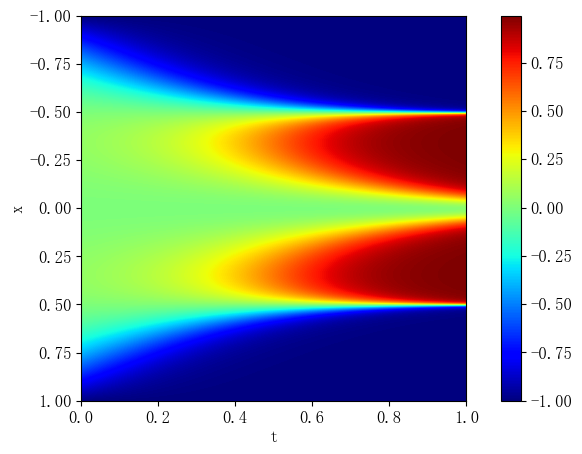

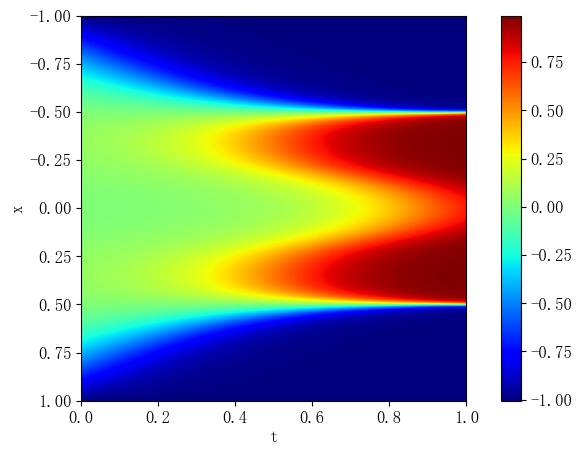

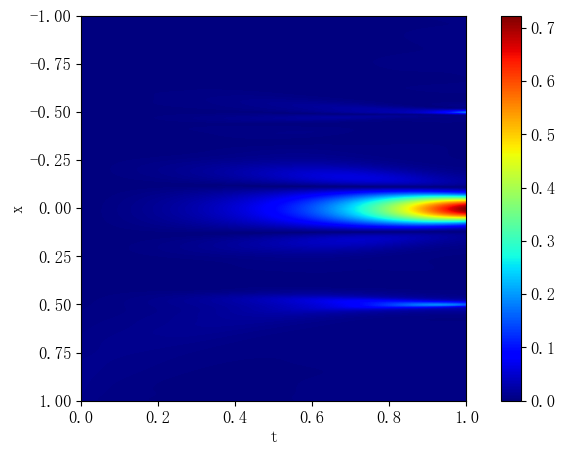

rmse: 0.06411918416740471  r2: 0.9909754711707556


In [26]:
####AC equation plotting（Hard constraint）
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'Hard Constraints AC.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(-1, 1, 51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = x**2*torch.cos(math.pi*x) + t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*(x+1)/2-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output
    
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_t-0.0001*h_xx+5*h**3-5*h     
        f = lossa(f1, 0 * f1)
        return f

    def loss_BC(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        f = lossa(h1-h2, 0*h1)
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        h2 = net(t,-x)
        h1_x = torch.autograd.grad(h1.sum(), x, create_graph=True)[0]
        h2_x = torch.autograd.grad(h2.sum(), x, create_graph=True)[0]
        f = lossa(h1_x-h2_x, 0*h1)
        return f


net = Net().to(device)
net.load_state_dict(torch.load('Hard Constraints AC.pt',map_location=device))   
data1 = genfromtxt("AC.csv", delimiter=',')
h00c=np.asarray(data1.data)
t_bc = np.linspace(0, 1, 201)
x_bc = np.linspace(-1, 1, 512)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1= h0.cpu().detach().numpy()
u1 = u1.reshape(ms_t.shape)
df = pd.DataFrame(u1) 
df.to_csv("0.001.csv")
c=df.iloc[-1]
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('FEM AC.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('Hard Constraints AC.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(h00c - u1), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,-1])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('ERROR Hard Constraints AC.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)


In [5]:
####vibrating string equation(dynamic boundary), comparison model (analytical solution), soft constraint.
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'VSE soft.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(0, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


####
t3 = np.linspace(0, 1, 51)
x3 = np.ones((1,1))
ms_t3, ms_x3 = np.meshgrid(t3, x3)
t3_pde = np.ravel(ms_t3).reshape(-1,1)
x3_pde = np.ravel(ms_x3).reshape(-1,1)
pt_x_collocation3 = Variable(torch.from_numpy(x3_pde).float(), requires_grad=True).to(device)
pt_t_collocation3 = Variable(torch.from_numpy(t3_pde).float(), requires_grad=True).to(device)

####
t4 = np.linspace(0, 1, 51)
x4 = np.zeros((1,1))
ms_t4, ms_x4 = np.meshgrid(t4, x4)
t4_pde = np.ravel(ms_t4).reshape(-1,1)
x4_pde = np.ravel(ms_x4).reshape(-1,1)
pt_x_collocation4 = Variable(torch.from_numpy(x4_pde).float(), requires_grad=True).to(device)
pt_t_collocation4 = Variable(torch.from_numpy(t4_pde).float(), requires_grad=True).to(device)


act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*x-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_tt-h_xx-(t**2-x**2)*torch.sin(x*t)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f1 = lossa(h, 0*h)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        f2 = lossa(h_t, x)
        f = f1+f2
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, torch.sin(t))
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f

tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(12000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2)+net.loss_BC(pt_t_collocation3, pt_x_collocation3)+net.loss_BC1(pt_t_collocation4, pt_x_collocation4)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:1.3736461400986
epoch:101,loss:0.0057737054303
epoch:201,loss:0.0015450837091
epoch:301,loss:0.0010716231773
epoch:401,loss:0.0008388228016
epoch:501,loss:0.0006882714806
epoch:601,loss:0.0005810603616
epoch:701,loss:0.0005042675184
epoch:801,loss:0.0004473674635
epoch:901,loss:0.0004028122348
epoch:1001,loss:0.0003658784844
epoch:1101,loss:0.0003337438393
epoch:1201,loss:0.0003046808415
epoch:1301,loss:0.0002775942849
epoch:1401,loss:0.0002517716493
epoch:1501,loss:0.0002267132222
epoch:1601,loss:0.0002069423208
epoch:1701,loss:0.0001810176764
epoch:1801,loss:0.0001619600516
epoch:1901,loss:0.0001411298144
epoch:2001,loss:0.0001257556141
epoch:2101,loss:0.0001063738455
epoch:2201,loss:0.0000959231547
epoch:2301,loss:0.0000789881087
epoch:2401,loss:0.0000966527950
epoch:2501,loss:0.0000589084593
epoch:2601,loss:0.0000565335940
epoch:2701,loss:0.0000448939682
epoch:2801,loss:0.0000430154614
epoch:2901,loss:0.0000356729142
epoch:3001,loss:0.0000393839000
epoch:3101,loss:0.00

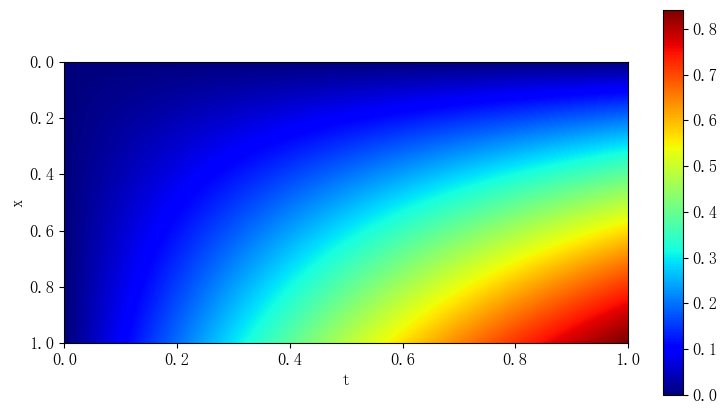

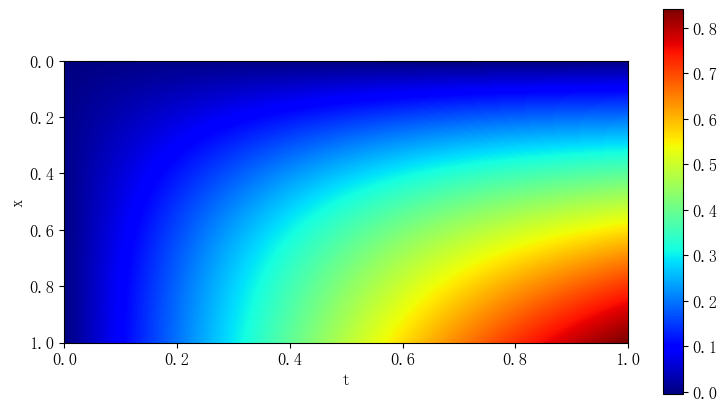

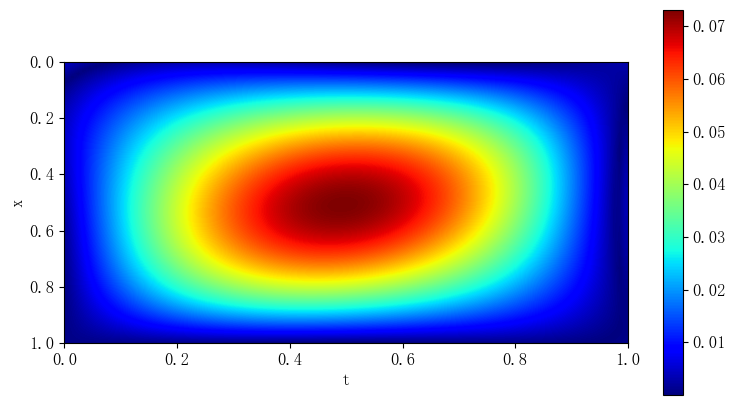

rmse: 0.03616679629004798  r2: 0.9686567998433838


In [6]:
####vibrating string equation plotting(dynamic boundary), comparison model (analytical solution), soft constraint.
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'VSE soft.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(0, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


####
t3 = np.linspace(0, 1, 51)
x3 = np.ones((1,1))
ms_t3, ms_x3 = np.meshgrid(t3, x3)
t3_pde = np.ravel(ms_t3).reshape(-1,1)
x3_pde = np.ravel(ms_x3).reshape(-1,1)
pt_x_collocation3 = Variable(torch.from_numpy(x3_pde).float(), requires_grad=True).to(device)
pt_t_collocation3 = Variable(torch.from_numpy(t3_pde).float(), requires_grad=True).to(device)

####
t4 = np.linspace(0, 1, 51)
x4 = np.zeros((1,1))
ms_t4, ms_x4 = np.meshgrid(t4, x4)
t4_pde = np.ravel(ms_t4).reshape(-1,1)
x4_pde = np.ravel(ms_x4).reshape(-1,1)
pt_x_collocation4 = Variable(torch.from_numpy(x4_pde).float(), requires_grad=True).to(device)
pt_t_collocation4 = Variable(torch.from_numpy(t4_pde).float(), requires_grad=True).to(device)


act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def forward(self, t, x):
        T =2*t-1
        X =2*x-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        output = self.output_layer(layer7_out)
        return output
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_tt-h_xx-(t**2-x**2)*torch.sin(x*t)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        f1 = lossa(h, 0*h)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        f2 = lossa(h_t, x)
        f = f1+f2
        return f
    def loss_BC(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, torch.sin(t))
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f
net = Net().to(device)
net.load_state_dict(torch.load('VSE soft.pt',map_location=device))   
t_bc = np.linspace(0, 1, 100)
x_bc = np.linspace(0, 1, 256)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
h00c=np.sin(x*t)

h00c = h00c.reshape(ms_t.shape)


config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1= h0.data.cpu().numpy()
u1 = u1.reshape(ms_t.shape)
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('exact VSE.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('pinn VSE soft.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(u1-h00c), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('error VSE soft.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)

In [7]:
####vibrating string equation(dynamic boundary), comparison model (analytical solution), hard constraint.
import time
import numpy as np
import torch
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'VSE hard.pt'
####
####
t = np.linspace(0, 1, 51)
x = np.linspace(0, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)

####
t4 = np.linspace(0, 1, 51)
x4 = np.zeros((1,1))
ms_t4, ms_x4 = np.meshgrid(t4, x4)
t4_pde = np.ravel(ms_t4).reshape(-1,1)
x4_pde = np.ravel(ms_x4).reshape(-1,1)
pt_x_collocation4 = Variable(torch.from_numpy(x4_pde).float(), requires_grad=True).to(device)
pt_t_collocation4 = Variable(torch.from_numpy(t4_pde).float(), requires_grad=True).to(device)

act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = torch.sin(t) + (x-1)*t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*x-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output    
    
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_tt-h_xx-(t**2-x**2)*torch.sin(x*t)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        f2 = lossa(h_t, x)
        f = f2
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f


tic = time.time()
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(),lr=5e-4)
lossa = torch.nn.MSELoss()
for i in range(12000):
    optimizer.zero_grad()
    if i % 100 == 0:
        torch.save(net.state_dict(), filepath_to_save_mode)
    loss1 = net.loss_pde(pt_t_collocation, pt_x_collocation)+net.loss_IC(pt_t_collocation2, pt_x_collocation2)+net.loss_BC1(pt_t_collocation4, pt_x_collocation4)
    loss = loss1
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'epoch:{i + 1},loss:{float(loss.mean()):.13f}')
toc = time.time()
torch.save(net.state_dict(), filepath_to_save_mode)
print('userd: {:.5f}s'.format(toc-tic))

epoch:1,loss:0.6258888244629
epoch:101,loss:0.0058008017950
epoch:201,loss:0.0008663855260
epoch:301,loss:0.0002591246448
epoch:401,loss:0.0001617125818
epoch:501,loss:0.0001191463525
epoch:601,loss:0.0000914984412
epoch:701,loss:0.0000709330707
epoch:801,loss:0.0000548893113
epoch:901,loss:0.0000424530190
epoch:1001,loss:0.0000329810682
epoch:1101,loss:0.0000258873624
epoch:1201,loss:0.0000207117646
epoch:1301,loss:0.0000171066276
epoch:1401,loss:0.0000150396754
epoch:1501,loss:0.0000135179507
epoch:1601,loss:0.0000153235505
epoch:1701,loss:0.0000117051713
epoch:1801,loss:0.0000110398350
epoch:1901,loss:0.0000115443518
epoch:2001,loss:0.0000101214973
epoch:2101,loss:0.0000097040756
epoch:2201,loss:0.0001154934434
epoch:2301,loss:0.0000091390339
epoch:2401,loss:0.0000087981216
epoch:2501,loss:0.0000085236434
epoch:2601,loss:0.0000091543234
epoch:2701,loss:0.0000081234539
epoch:2801,loss:0.0000078938474
epoch:2901,loss:0.0000130412927
epoch:3001,loss:0.0000075917660
epoch:3101,loss:0.00

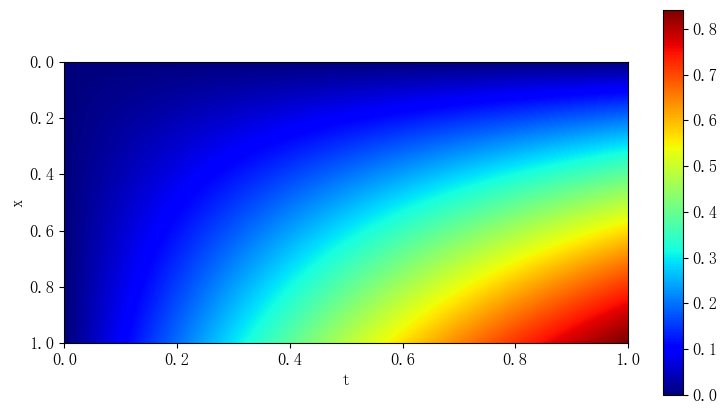

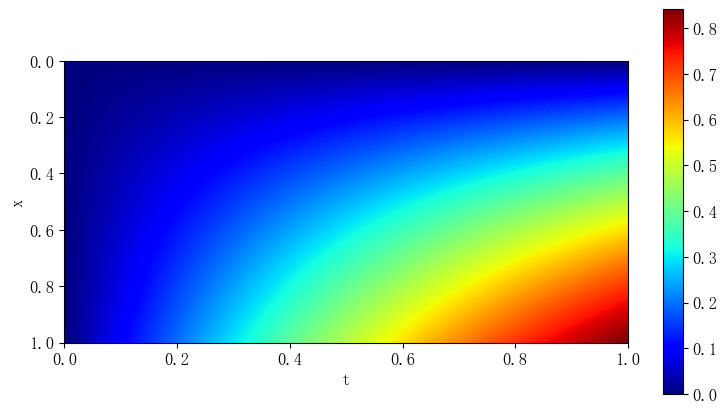

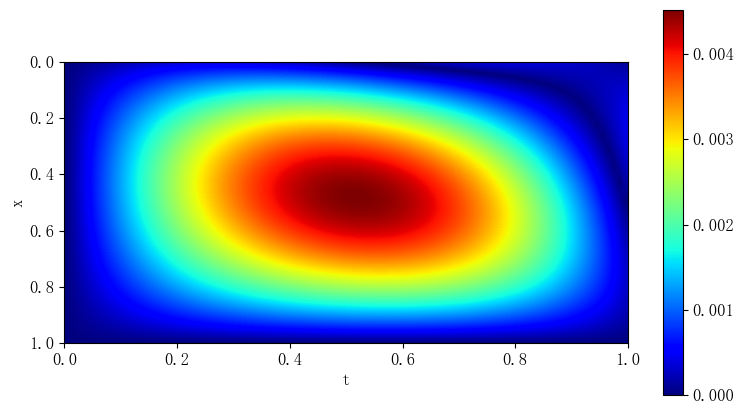

rmse: 0.0022447884317875768  r2: 0.9998792536289175


In [4]:
####vibrating string equation plotting(dynamic boundary), comparison model (analytical solution), hard constraint.
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math
from sympy import *
import torch.nn.functional as F
from numpy import genfromtxt
torch.manual_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filepath_to_save_mode = 'VSE hard.pt'
t = np.linspace(0, 1, 51)
x = np.linspace(0, 1,51)
ms_t, ms_x = np.meshgrid(t, x)
t_pde = np.ravel(ms_t).reshape(-1,1)
x_pde = np.ravel(ms_x).reshape(-1,1)
pt_x_collocation = Variable(torch.from_numpy(x_pde).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_pde).float(), requires_grad=True).to(device)

####
t2 = np.zeros((1,1))
x2 = np.linspace(1, 1, 51)
ms_t2, ms_x2 = np.meshgrid(t2, x2)
t2_pde = np.ravel(ms_t2).reshape(-1,1)
x2_pde = np.ravel(ms_x2).reshape(-1,1)
pt_x_collocation2 = Variable(torch.from_numpy(x2_pde).float(), requires_grad=True).to(device)
pt_t_collocation2 = Variable(torch.from_numpy(t2_pde).float(), requires_grad=True).to(device)


act = nn.Tanh()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64, 64)
        self.hidden_layer3 = nn.Linear(64, 64)
        self.hidden_layer4 = nn.Linear(64, 64)
        self.hidden_layer5 = nn.Linear(64, 64)
        self.hidden_layer6 = nn.Linear(64, 64)
        self.hidden_layer7 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
    def Hard_Constraints(self, t, x, nn_outputs):
        output_hard = torch.sin(t) + (x-1)*t * nn_outputs
        return output_hard
    def forward(self, t, x):
        T =2*t-1
        X =2*x-1
        inputs = torch.cat([T, X], dim=1)
        layer1_out = act(self.hidden_layer1(inputs))
        layer2_out = act(self.hidden_layer2(layer1_out))
        layer3_out = act(self.hidden_layer3(layer2_out))
        layer4_out = act(self.hidden_layer4(layer3_out))
        layer5_out = act(self.hidden_layer5(layer4_out))
        layer6_out = act(self.hidden_layer6(layer5_out))
        layer7_out = act(self.hidden_layer7(layer6_out))
        nn_output = self.output_layer(layer7_out)
        output = self.Hard_Constraints(t, x,nn_output)
        return output    
    
    def loss_pde(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        h_tt = torch.autograd.grad(h_t.sum(), t, create_graph=True)[0]
        h_x = torch.autograd.grad(h.sum(), x, create_graph=True)[0]
        h_xx = torch.autograd.grad(h_x.sum(), x, create_graph=True)[0]
        f1 = h_tt-h_xx-(t**2-x**2)*torch.sin(x*t)
        f = lossa(f1, 0 * f1)
        return f
    def loss_IC(net,t, x):
        h =net(t,x)
        h_t = torch.autograd.grad(h.sum(), t, create_graph=True)[0]
        f2 = lossa(h_t, x)
        f = f2
        return f
    def loss_BC1(net,t, x):
        h1 =net(t,x)
        f = lossa(h1, 0*h1)
        return f

net = Net().to(device)
net.load_state_dict(torch.load('VSE hard.pt',map_location=device))   
t_bc = np.linspace(0, 1, 100)
x_bc = np.linspace(0, 1, 256)
ms_t, ms_x = np.meshgrid(t_bc, x_bc)
t = np.ravel(ms_t).reshape(-1,1)
x = np.ravel(ms_x).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)   
h0 = net(pt_t,pt_x)
h00c=np.sin(x*t)

h00c = h00c.reshape(ms_t.shape)


config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
            'axes.unicode_minus': False 
         }
rcParams.update(config)
u1=h0.data.cpu().numpy()
u1 = u1.reshape(ms_t.shape)
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(h00c, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('exact VSE.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(u1, cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('pinn VSE hard.png', dpi=600, bbox_inches='tight') 
plt.show()
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.imshow(abs(u1-h00c), cmap='jet', interpolation='bilinear', aspect=0.5, extent=[0,1,1,0])
plt.colorbar()
plt.ylabel('x')
plt.xlabel('t')
plt.savefig('error VSE hard.png', dpi=600, bbox_inches='tight') 
plt.show()
mse = (np.sum((h00c - u1) ** 2))/len(pt_x)
rmse = mse**0.5
r2 = 1-mse/ np.var(h00c)
print("rmse:",rmse," r2:",r2)